# Big Query Rai Data Acquisition and Analysis

In this notebook, we will query Rai system data from Google's Big Query and create the same datasets seen in (TheGraphDataSetCreation.ipynb)[TheGraphDataSetCreation.ipynb] with higher fidelity.


Access and libraries were was obtained by from the following tutorials:
* https://cloud.google.com/docs/authentication/getting-started#cloud-console
* https://cloud.google.com/bigquery/docs/pandas-gbq-migration


## Data Fields required (Data point: Big Query table)
* Total Supply
* Global Debt
* Redemption Price: OracleRelayer_event_UpdateRedemptionPrice
* Redemption Rate
* Debt ceiling
* Rai market price
* Total Collateral
* ETH Price (Next OSM): ChainlinkMedianETHUSD_event_UpdateResult
* Eth Price (OSM): OSM_event_UpdateResult
* System surplus
* Active safes
* Surplus
* Debt to settle
* Uniswap pool information


In [1]:
# import libraries
import os
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

%matplotlib inline

# constants
constant = 1000000000000000000

#defining creditionals
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/aclarkdata/Downloads/raidata-5e1723d42cf5.json'

# initializing agent
client = bigquery.Client()


In [2]:
# SQL query
sql = """
SELECT * 
FROM `blockchain-etl.ethereum_rai.ChainlinkMedianETHUSD_event_UpdateResult`
ORDER By block_timestamp DESC

"""

eth_price_next_OSM = client.query(sql).to_dataframe()

In [3]:
eth_price_next_OSM['ETH Price (Next OSM)'] = eth_price_next_OSM['medianPrice'].astype(float)/constant
del eth_price_next_OSM['medianPrice']

eth_price_next_OSM.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,lastUpdateTime,ETH Price (Next OSM)
0,2021-04-19 15:08:01+00:00,12271233,0xeb2a5dc15e601c1116876add33842c21595319a15e9e...,48,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618844881,2129.458042
1,2021-04-19 14:07:33+00:00,12270946,0x7da0480193071151144ffaf7cf92fd624d2bc40656d9...,47,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618841253,2219.590000
2,2021-04-19 12:49:28+00:00,12270590,0x0cc57cc1b88720bd73869bbc4c9a930acc1f1e80c87f...,180,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618836568,2244.796301
3,2021-04-19 11:38:10+00:00,12270259,0x5510eba853ce5d961e402714c83e9303cf553d672b75...,183,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618832290,2236.288682
4,2021-04-19 10:27:55+00:00,12269966,0x0f654a24665353b782f6975789dbc319412d61583cee...,103,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618828075,2218.569789


In [4]:

# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.OSM_event_UpdateResult`
ORDER By block_timestamp DESC

"""

eth_price_OSM = client.query(sql).to_dataframe()
eth_price_OSM['ETH Price (OSM)'] = eth_price_OSM['newMedian'].astype(float)/constant
del eth_price_OSM['newMedian']

eth_price_OSM.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,lastUpdateTime,ETH Price (OSM)
0,2021-04-22 13:09:45+00:00,12290195,0x3ec1286750e8f0fb1ee920210b97a3f73bf795f56357...,167,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1619096400,2562.495293
1,2021-04-22 12:10:35+00:00,12289914,0xe3c8412f44bcc2cca5ed69fcd9ef96f0608593490bb7...,134,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1619092800,2522.318413
2,2021-04-22 11:09:37+00:00,12289641,0x75bfc53cc4948319df6c174aa6e5b882dda508877473...,356,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1619089200,2484.300000
3,2021-04-22 10:09:42+00:00,12289362,0x2144bd0064bab18f0e850525ed8d9e4405d0ccd72211...,101,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1619085600,2445.375952
4,2021-04-22 09:09:46+00:00,12289102,0x3de061c8827df60855646832d1942b83707c7125c8c2...,96,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1619082000,2457.967104


In [5]:
import json
import requests
url = 'https://api.thegraph.com/subgraphs/name/reflexer-labs/rai-mainnet'

blocknumbers = eth_price_OSM.block_number.values.tolist()

state = []
for i in blocknumbers:
    query = '''
    {
      systemState(block: {number:%s},id:"current") { 
        coinUniswapPair {
          reserve0
          reserve1
        }
        currentCoinMedianizerUpdate{
          value
        }
        currentRedemptionRate {
          eightHourlyRate
          annualizedRate
          hourlyRate
          createdAt
        }
        currentRedemptionPrice {
          value
        }
        erc20CoinTotalSupply
        globalDebt
        globalDebtCeiling
        totalActiveSafeCount
        coinAddress
        wethAddress
        systemSurplus
        debtAvailableToSettle
        lastPeriodicUpdate
        createdAt
        createdAtBlock
      }
    }
    ''' % i
    r = requests.post(url, json = {'query':query})
    s = json.loads(r.content)['data']['systemState']
    state.append(s)
        
systemState = pd.DataFrame(state)

systemState['block_number'] = blocknumbers


systemState.head()
    


,coinAddress,coinUniswapPair,createdAt,createdAtBlock,currentCoinMedianizerUpdate,currentRedemptionPrice,currentRedemptionRate,debtAvailableToSettle,erc20CoinTotalSupply,globalDebt,globalDebtCeiling,lastPeriodicUpdate,systemSurplus,totalActiveSafeCount,wethAddress,block_number
0,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '20370866.669629009413558538', 'r...",1529678381,5834717,{'value': '3.060827031579657558'},{'value': '3.016038360758282175147444116'},{'annualizedRate': '0.955078817010394883197407...,3250.30351111138800363039848642042,30927713.569045613275392485,31200867.44959972898309079610917869,115792089237316195423570985008687.9,1619094569,202768.9325992876691911837903000856,713,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12290195
1,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '20247590.940076599216520856', 'r...",1529678381,5834717,{'value': '3.060827031579657558'},{'value': '3.016053965374196123656761213'},{'annualizedRate': '0.955078817010394883197407...,3250.30351111138800363039848642042,30856017.426391014159996665,31129075.86523090362408579426566877,115792089237316195423570985008687.9,1619090005,202728.9264177001520689262978715171,715,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12289914
2,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '20117345.358834566306369096', 'r...",1529678381,5834717,{'value': '3.030668528634175772'},{'value': '3.016085777062387388111204856'},{'annualizedRate': '0.955078817010394883197407...,3250.30351111138800363039848642042,30819017.426391014159996665,31091971.48404066237147303164338649,115792089237316195423570985008687.9,1619085473,202667.2588988780399103451828993885,714,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12289641
3,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '19979406.473249981775489011', 'r...",1529678381,5834717,{'value': '3.030668528634175772'},{'value': '3.016085847393975234410368508'},{'annualizedRate': '0.955078817010394883197407...,2407.254511111388003629651242726791,30819978.502251014159996666,31091971.48404066237147303164338649,115792089237316195423570985008687.9,1619085473,202549.2320388780399103449301430821,715,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12289362
4,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '19938323.733123762100443225', 'r...",1529678381,5834717,{'value': '3.030668528634175772'},{'value': '3.016128084996986289819939133'},{'annualizedRate': '0.934420241007220245650819...,2407.254511111388003629651242726791,30821571.49805366185014293,31093456.18989747490087158558588016,115792089237316195423570985008687.9,1619080237,202498.1241388974391085266172876581,717,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12289102


In [6]:
systemState.tail()

,coinAddress,coinUniswapPair,createdAt,createdAtBlock,currentCoinMedianizerUpdate,currentRedemptionPrice,currentRedemptionRate,debtAvailableToSettle,erc20CoinTotalSupply,globalDebt,globalDebtCeiling,lastPeriodicUpdate,systemSurplus,totalActiveSafeCount,wethAddress,block_number
1584,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '801.933726709008306816', 'reserv...",1529678381,5834717,{'value': '0'},{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,3048.440432971667032725,3048.645954953510904626288422086589,115792089237316195423570985008687.9,1613394096,0.1161617985274885650688366678947734,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11861502
1585,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '676.933726709008306816', 'reserv...",1529678381,5834717,None,{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,2788.440432971667032725,2788.657935201718685876567866781341,115792089237316195423570985008687.9,1613384616,0.1087511150258265757085590152709335,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11861237
1586,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '676.933726709008306816', 'reserv...",1529678381,5834717,None,{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,2788.440432971667032725,2788.657935201718685876567866781341,115792089237316195423570985008687.9,1613384616,0.1087511150258265757085590152709335,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11861008
1587,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '676.933726709008306816', 'reserv...",1529678381,5834717,None,{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,2788.440432971667032725,2788.522357955470745187436691184972,115792089237316195423570985008687.9,1613338681,0.06853325908830422221834559248594176,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11860755
1588,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,None,1529678381,5834717,None,None,None,0,0,0,0,0,0,0,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11848351


In [7]:
systemState.columns

Index(['coinAddress', 'coinUniswapPair', 'createdAt', 'createdAtBlock',
       'currentCoinMedianizerUpdate', 'currentRedemptionPrice',
       'currentRedemptionRate', 'debtAvailableToSettle',
       'erc20CoinTotalSupply', 'globalDebt', 'globalDebtCeiling',
       'lastPeriodicUpdate', 'systemSurplus', 'totalActiveSafeCount',
       'wethAddress', 'block_number'],
      dtype='object')

In [8]:
systemState.drop(systemState.tail(1).index,inplace=True) # drop last row

systemState['coinUniswapPair'].tail()

1583    {'reserve0': '801.933726709008306816', 'reserv...
1584    {'reserve0': '801.933726709008306816', 'reserv...
1585    {'reserve0': '676.933726709008306816', 'reserv...
1586    {'reserve0': '676.933726709008306816', 'reserv...
1587    {'reserve0': '676.933726709008306816', 'reserv...
Name: coinUniswapPair, dtype: object

In [9]:
systemState['RedemptionRateAnnualizedRate'] = systemState.currentRedemptionRate.apply(lambda x: x['annualizedRate'])
systemState['RedemptionRateHourlyRate'] = systemState.currentRedemptionRate.apply(lambda x: x['hourlyRate'])
systemState['RedemptionRateEightHourlyRate'] = systemState.currentRedemptionRate.apply(lambda x: x['eightHourlyRate'])
systemState['RedemptionPrice'] = systemState.currentRedemptionPrice.apply(lambda x: x['value'])
systemState['RAIInUniswapV2(RAI/ETH)'] = systemState.coinUniswapPair.apply(lambda x: x['reserve0'])
del systemState['currentRedemptionRate']
del systemState['currentRedemptionPrice']
systemState['RedemptionRateAnnualizedRate'] = systemState['RedemptionRateAnnualizedRate'].astype(float)
systemState['RedemptionRateHourlyRate'] = systemState['RedemptionRateHourlyRate'].astype(float)
systemState['RedemptionRateEightHourlyRate'] = systemState['RedemptionRateEightHourlyRate'].astype(float)
systemState['RedemptionPrice'] = systemState['RedemptionPrice'].astype(float)
systemState['RAIInUniswapV2(RAI/ETH)'] = systemState['RAIInUniswapV2(RAI/ETH)'].astype(float)



In [10]:
len(systemState)

1588

In [11]:
len(eth_price_OSM)

1589

In [12]:
systemState['timestampDiff'] = systemState['createdAt'].astype(float).diff() * -1
systemState['timestampDiff'] = systemState['timestampDiff'][1:-2]
systemState['timestampDiff'].describe()

count    1585.0
mean        0.0
std         0.0
min        -0.0
25%        -0.0
50%        -0.0
75%        -0.0
max        -0.0
Name: timestampDiff, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


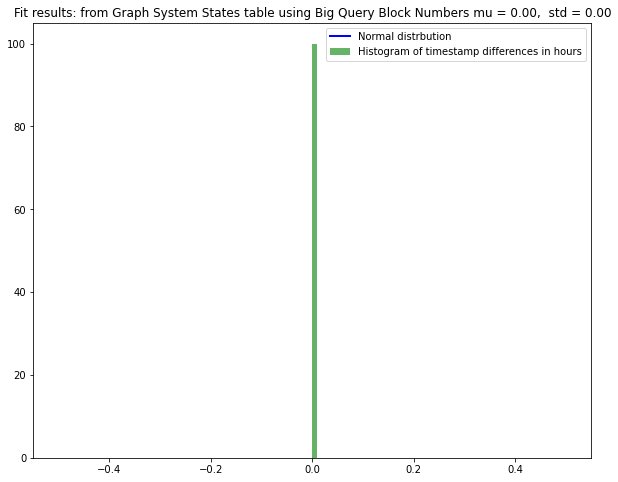

In [36]:
# convert to hours
data = systemState.timestampDiff[1:-3].apply(lambda x: x/3600)

# Fit a normal distribution to the data:
mu, std = stats.norm.fit(data)
plt.figure(figsize=(10, 8))
# Plot the histogram.
plt.hist(data, bins=100, density=True, alpha=0.6, color='g',label='Histogram of timestamp differences in hours')

# Plot the PDF.
x = np.linspace(0, 3, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, color = 'b',label ='Normal distrbution')
title = "Fit results: from Graph System States table using Big Query Block Numbers mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.legend()

plt.show()

## Time Analysis

In [14]:
eth_price_OSM['timestampDiff'] = eth_price_OSM['lastUpdateTime'].astype(float).diff() * -1
eth_price_OSM['timestampDiff'] = eth_price_OSM['timestampDiff'][1:-2]
eth_price_OSM['timestampDiff'].describe()

count    1586.0
mean     3600.0
std         0.0
min      3600.0
25%      3600.0
50%      3600.0
75%      3600.0
max      3600.0
Name: timestampDiff, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


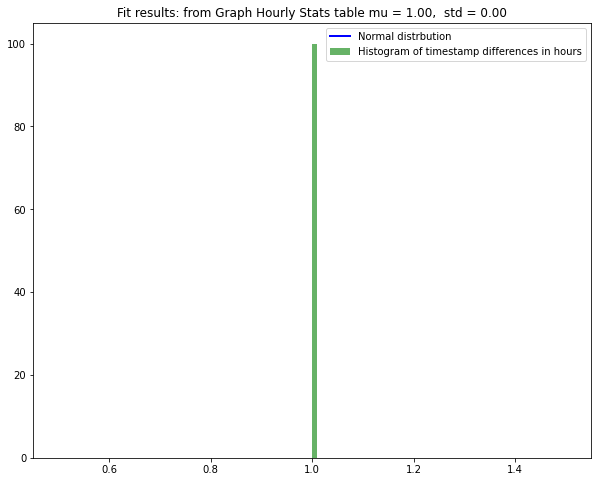

In [15]:
# convert to hours
data = eth_price_OSM.timestampDiff[1:-3].apply(lambda x: x/3600)

# Fit a normal distribution to the data:
mu, std = stats.norm.fit(data)
plt.figure(figsize=(10, 8))
# Plot the histogram.
plt.hist(data, bins=100, density=True, alpha=0.6, color='g',label='Histogram of timestamp differences in hours')

# Plot the PDF.
x = np.linspace(0, 3, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, color = 'b',label ='Normal distrbution')
title = "Fit results: from Graph Hourly Stats table mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.legend()

plt.show()

In [16]:
subset_eth = eth_price_OSM[['ETH Price (OSM)','block_number']]

In [17]:
master = eth_price_next_OSM.merge(systemState,how='inner',on='block_number')
master = master.merge(subset_eth,how='inner',on='block_number')

In [18]:
master.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,lastUpdateTime,ETH Price (Next OSM),coinAddress,coinUniswapPair,createdAt,...,systemSurplus,totalActiveSafeCount,wethAddress,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH),timestampDiff,ETH Price (OSM)
0,2021-04-05 23:09:57+00:00,12182570,0x97d4f653d6913c9cc85b5498df332e895ef6d079b2c3...,282,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1617664197,2104.170974,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '31041801.125122501466135463', 'r...",1529678381,...,187338.5959485606686820321694960594,984,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.893578,0.999987,0.999897,3.030509,3.104180e+07,-0.0,2117.650000
1,2021-04-02 20:09:56+00:00,12162180,0x54b61efbebaadaf3cc7df50be548ec642d427c78a566...,231,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1617394196,2072.713775,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '32035699.997107805187441075', 'r...",1529678381,...,184264.3263143241582880245129434617,981,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.846295,0.999981,0.999848,3.033423,3.203570e+07,-0.0,2052.464741
2,2021-04-02 07:13:07+00:00,12158673,0xd1a62352415d08be52cd4cebfefd7811bb0f3c5093da...,259,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1617347587,1998.000000,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '31509283.060081752223705783', 'r...",1529678381,...,183712.5657625425875127865653801174,983,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.911912,0.999989,0.999916,3.034000,3.150928e+07,-0.0,1991.766574
3,2021-03-29 12:09:57+00:00,12134065,0x7fa7fb984f80e92dcf64f523fb5ceac5c55cc331ffc5...,364,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1617019797,1777.289555,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '36225653.949187886673282187', 'r...",1529678381,...,179640.3035482553016037784209888087,999,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.242260,1.000025,1.000198,3.033300,3.622565e+07,-0.0,1767.251649
4,2021-03-25 20:09:47+00:00,12110194,0x3259bdf3aad1248337c27b9cba2ff9fb5127a89a0d6d...,41,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1616702987,1607.400000,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '34427813.290379045822885935', 'r...",1529678381,...,175617.172673347380380196043242654,993,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.395665,1.000038,1.000304,3.027886,3.442781e+07,-0.0,1602.851185


In [19]:
master.to_csv('saved_results/Graph+BigQuerySystemData.csv')

## Additional

In [20]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.OracleRelayer_event_UpdateRedemptionPrice`
ORDER By block_timestamp DESC

"""

redemptionPrice = client.query(sql).to_dataframe()

redemptionPrice['RAI Redemption Price'] = redemptionPrice['redemptionPrice'].astype(float)/constant
del redemptionPrice['redemptionPrice']
redemptionPrice.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,RAI Redemption Price
0,2021-04-22 13:54:28+00:00,12290399,0x343de2bc60f758e9c2711386595f1cc1530b611b9dc6...,222,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.016027e+09
1,2021-04-22 13:09:45+00:00,12290195,0xaaed129d06ed5e8243e2f7b6042e677ab669fe421d63...,168,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.016038e+09
2,2021-04-22 12:10:35+00:00,12289914,0x8ed60879bfef10e3439f2385e4b68e9f212ce0c1908f...,135,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.016054e+09
3,2021-04-22 11:13:17+00:00,12289657,0x07e178c95a647c3b769bbbb7af46f29d7463b349c18e...,267,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.016069e+09
4,2021-04-22 10:09:58+00:00,12289364,0x8bf422f550f2f398128fb5563dc0bfb7a633bc418b39...,84,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.016086e+09


In [21]:
redemptionPrice['RAI Redemption Price']

0       3.016027e+09
1       3.016038e+09
2       3.016054e+09
3       3.016069e+09
4       3.016086e+09
            ...     
2098    3.140000e+09
2099    3.140000e+09
2100    3.140000e+09
2101    3.140000e+09
2102    3.140000e+09
Name: RAI Redemption Price, Length: 2103, dtype: float64

In [22]:
systemState['RedemptionPrice']

0       3.016038
1       3.016054
2       3.016086
3       3.016086
4       3.016128
          ...   
1583    3.140000
1584    3.140000
1585    3.140000
1586    3.140000
1587    3.140000
Name: RedemptionPrice, Length: 1588, dtype: float64

## Safe events

All safe Big Query events:

### Un-used
* SAFEEngine_event_AddAuthorization
* SAFEEngine_event_ApproveSAFEModification 
* SAFEEngine_event_CreateUnbackedDebt
* SAFEEngine_event_DenySAFEModification
* SAFEEngine_event_DisableContract
* SAFEEngine_event_InitializeCollateralType
* SAFEEngine_event_RemoveAuthorization
* SAFEEngine_event_TransferSAFECollateralAndDebt


### Used:
* SAFEEngine_event_ConfiscateSAFECollateralAndDebt
* SAFEEngine_event_ModifyCollateralBalance
* SAFEEngine_event_ModifyParameters
* SAFEEngine_event_ModifySAFECollateralization
* SAFEEngine_event_SettleDebt
* SAFEEngine_event_TransferCollateral
* SAFEEngine_event_TransferInternalCoins
* SAFEEngine_event_UpdateAccumulatedRate

In [23]:
# SQL query -- forced liquiditation 
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_ConfiscateSAFECollateralAndDebt`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_ConfiscateSAFECollateralAndDebt = client.query(sql).to_dataframe()
SAFEEngine_event_ConfiscateSAFECollateralAndDebt['Event'] = 'SAFEEngine_event_ConfiscateSAFECollateralAndDebt'
SAFEEngine_event_ConfiscateSAFECollateralAndDebt.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,safe,collateralCounterparty,debtCounterparty,deltaCollateral,deltaDebt,globalUnbackedDebt,Event
0,2021-04-22 10:09:58+00:00,12289364,0x8bf422f550f2f398128fb5563dc0bfb7a633bc418b39...,73,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x18ff2c9e0236a596fd294dd8f1f5ab774135fa8a,0x27efc6ffe79692e0521e7e27657cf228240a06c2,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,-1500000000000000000,-839954335892798364322,3250303511111388003630398486420419825856105220762,SAFEEngine_event_ConfiscateSAFECollateralAndDebt
1,2021-04-18 13:00:26+00:00,12264219,0x6087bae12fc44a7448e9a26bc02ceee93263530c5474...,35,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xd0d403427b1018fd47ff18911eab2fca914a8451,0x27efc6ffe79692e0521e7e27657cf228240a06c2,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,-2500000000000000000,-1199575073796859981982,3307254511111388003630653718953832290789070624990,SAFEEngine_event_ConfiscateSAFECollateralAndDebt
2,2021-04-14 11:00:07+00:00,12237813,0x6cdf928480223693fb4c865841832d5b150d9123cd78...,5,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x605f13ea976cb9fe9afb990301e1c545a3d3c0ad,0x27efc6ffe79692e0521e7e27657cf228240a06c2,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,-2220000000000000000,-1199623529590242599057,2103518374295953903228734667282724195848981712914,SAFEEngine_event_ConfiscateSAFECollateralAndDebt
3,2021-04-07 19:01:37+00:00,12194464,0x56672448531e1ca05a1af3da8a7cdb32949a8969f42a...,29,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x9652bbb5b9b056ba4a14ffe7b75eb9bd6fa1be5a,0x27efc6ffe79692e0521e7e27657cf228240a06c2,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,-2000000000000000000,-897411436975615760498,900000000000000000001002476227041394075821743724,SAFEEngine_event_ConfiscateSAFECollateralAndDebt
4,2021-03-24 21:00:16+00:00,12103880,0x80984fdcd2c61cd36ef4b500fc0c575f87575b8b1361...,61,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x0899634fb88cc1ff5d1f43ca087f0a709ac42a5f,0x27efc6ffe79692e0521e7e27657cf228240a06c2,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,-7000000000000000000,-2596958194905361160377,4975545276765162608995551015657265162886714670...,SAFEEngine_event_ConfiscateSAFECollateralAndDebt


In [24]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_ModifyCollateralBalance`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_ModifyCollateralBalance = client.query(sql).to_dataframe()
SAFEEngine_event_ModifyCollateralBalance['Event'] = 'SAFEEngine_event_ModifyCollateralBalance'
SAFEEngine_event_ModifyCollateralBalance.head()


,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,account,wad,Event
0,2021-04-22 13:19:04+00:00,12290242,0x2d99bddfb340152d6903b6beebd1d788d01a59461726...,166,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x024b84e6f214ce7b56cd20742c54cc352d11298c,35417768639576199833,SAFEEngine_event_ModifyCollateralBalance
1,2021-04-22 12:51:21+00:00,12290109,0x5c74b6cc60de7b18b651b90e8baae5d5e3a1006d8bac...,188,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xe29521d69b9ef25996c3700488ff96d8a69f9614,4200000000000000000,SAFEEngine_event_ModifyCollateralBalance
2,2021-04-22 12:15:27+00:00,12289940,0x2b2cd129c360423b3b1d1c129f60a07daac356f3f29a...,33,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xab36e5f05bfeefd44891d83e1ea1288b1079e9a0,-500000000000000000000,SAFEEngine_event_ModifyCollateralBalance
3,2021-04-22 12:12:52+00:00,12289927,0xd3ba86390af7c86a752199b55fdc00cdfdf4c517a6a9...,197,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xadf5560defab60ad19c205ce81868e3d8894fdee,-8000000000000000000,SAFEEngine_event_ModifyCollateralBalance
4,2021-04-22 12:10:57+00:00,12289917,0x44ebb60ca10a643f7ef97f883e329dc7fc31cf2a2387...,132,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xadf5560defab60ad19c205ce81868e3d8894fdee,-7000000000000000000,SAFEEngine_event_ModifyCollateralBalance


In [25]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_ModifyParameters`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_ModifyParameters = client.query(sql).to_dataframe()
SAFEEngine_event_ModifyParameters['Event'] = 'SAFEEngine_event_ModifyParameters'
SAFEEngine_event_ModifyParameters.head()



,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,parameter,data,Event
0,2021-04-22 13:09:45+00:00,12290195,0xaaed129d06ed5e8243e2f7b6042e677ab669fe421d63...,170,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x6c69717569646174696f6e5072696365000000000000...,585946835546249734079866378496,SAFEEngine_event_ModifyParameters
1,2021-04-22 13:09:45+00:00,12290195,0xaaed129d06ed5e8243e2f7b6042e677ab669fe421d63...,169,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x73616665747950726963650000000000000000000000...,585946835546249734079866378496,SAFEEngine_event_ModifyParameters
2,2021-04-22 12:10:35+00:00,12289914,0x8ed60879bfef10e3439f2385e4b68e9f212ce0c1908f...,137,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x6c69717569646174696f6e5072696365000000000000...,576756901507382566091657628178,SAFEEngine_event_ModifyParameters
3,2021-04-22 12:10:35+00:00,12289914,0x8ed60879bfef10e3439f2385e4b68e9f212ce0c1908f...,136,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x73616665747950726963650000000000000000000000...,576756901507382566091657628178,SAFEEngine_event_ModifyParameters
4,2021-04-22 11:13:17+00:00,12289657,0x07e178c95a647c3b769bbbb7af46f29d7463b349c18e...,268,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x73616665747950726963650000000000000000000000...,568060711031309144608731565946,SAFEEngine_event_ModifyParameters


In [26]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_ModifySAFECollateralization`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_ModifySAFECollateralization = client.query(sql).to_dataframe()
SAFEEngine_event_ModifySAFECollateralization['Event'] = 'SAFEEngine_event_ModifySAFECollateralization'
SAFEEngine_event_ModifySAFECollateralization.head()



,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,safe,collateralSource,debtDestination,deltaCollateral,deltaDebt,lockedCollateral,generatedDebt,globalDebt,Event
0,2021-04-22 13:49:25+00:00,12290377,0x60db869ff7eebd3f6524c44480fb9f8348ba2d37a523...,264,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x8288644218c552a415d705bcef227535fdc2d8d3,0x8288644218c552a415d705bcef227535fdc2d8d3,0x8288644218c552a415d705bcef227535fdc2d8d3,0,9963205089480913182972,246000000000000000000,105218929967458832899826,3124994236833264915926230895468910913799837160...,SAFEEngine_event_ModifySAFECollateralization
1,2021-04-22 13:19:04+00:00,12290242,0x2d99bddfb340152d6903b6beebd1d788d01a59461726...,142,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x867366d666cc9205a8255a4e376127fe2c5e1b92,0x867366d666cc9205a8255a4e376127fe2c5e1b92,0x867366d666cc9205a8255a4e376127fe2c5e1b92,0,29889649446449066006486,642983425058629342660,287754881899347439645742,3123990665001949457287298418789752015087556698...,SAFEEngine_event_ModifySAFECollateralization
2,2021-04-22 13:19:04+00:00,12290242,0x2d99bddfb340152d6903b6beebd1d788d01a59461726...,169,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x867366d666cc9205a8255a4e376127fe2c5e1b92,0x024b84e6f214ce7b56cd20742c54cc352d11298c,0x024b84e6f214ce7b56cd20742c54cc352d11298c,35417768639576199833,0,678401193698205542493,287754881899347439645742,3123990665001949457287298418789752015087556698...,SAFEEngine_event_ModifySAFECollateralization
3,2021-04-22 13:10:44+00:00,12290202,0x0ea6a9f2adc727e6bcc2fd02f098ddc4372fb025fd9b...,79,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xde6ba261b9fa1688ea8953e294168b2feff75559,0xde6ba261b9fa1688ea8953e294168b2feff75559,0xde6ba261b9fa1688ea8953e294168b2feff75559,0,8966897649258544571278,207000000000000000000,108973347547433270556590,3120989685211094913755929726171866708580759870...,SAFEEngine_event_ModifySAFECollateralization
4,2021-04-22 12:51:21+00:00,12290109,0x5c74b6cc60de7b18b651b90e8baae5d5e3a1006d8bac...,191,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x8ac216352fa44fd4183f5b829160c60b1879b94e,0xe29521d69b9ef25996c3700488ff96d8a69f9614,0xe29521d69b9ef25996c3700488ff96d8a69f9614,4200000000000000000,0,7321000000000000000,804013320102976804973,3119905716344224622405203475450894810481868867...,SAFEEngine_event_ModifySAFECollateralization


In [27]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_SettleDebt`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_SettleDebt = client.query(sql).to_dataframe()
SAFEEngine_event_SettleDebt['Event'] ='SAFEEngine_event_SettleDebt'
SAFEEngine_event_SettleDebt.head()





,block_timestamp,block_number,transaction_hash,log_index,contract_address,account,rad,debtBalance,coinBalance,globalUnbackedDebt,globalDebt,Event
0,2021-04-19 19:18:03+00:00,12272342,0xa2e25da20dfa5e9661688a6306d30e188fa643a34793...,272,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,900000000000000000001002476227041394075821743724,2407254511111388003629651242726790896713248881266,2027222635903069537228225155558321180668950003...,2407254511111388003629651242726790896713248881266,3032703826686624218402396798085518690594436681...,SAFEEngine_event_SettleDebt
1,2021-04-05 21:18:09+00:00,12182046,0x1f34492ec163ced86ef574826e6c9287b9bfb595244f...,264,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,5603430161389239180606453093315274126512479833728,0,1872558497830529247947215752867020300254022494...,0,3589662694365543038392278353146660187958136633...,SAFEEngine_event_SettleDebt
2,2021-04-03 21:18:56+00:00,12168983,0xd151b8e0ea6f43b3455217c6aafb42df6fbc18ddc528...,327,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,6000429200374285858342000749775368314273311672578,5603430161389239180606453093315274126512479833728,1908979296633846669850130065783923262184556123...,5603430161389239180606453093315274126512479833728,3550250021126473512710125816323988061362216357...,SAFEEngine_event_SettleDebt
3,2021-04-03 10:21:01+00:00,12166026,0xd1aa757fc323f0835804dfbcc433dce30bd96878b880...,199,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,2040000000000000000000595693274620755795645070848,1160385936176352503894845384309064244078579150...,1964650467937389117898754004998698561610466825...,1160385936176352503894845384309064244078579150...,3708530227106896330512529742600356102876252871...,SAFEEngine_event_SettleDebt
4,2021-03-30 21:20:02+00:00,12143061,0x4d66fc12a8209942e5a08badb1ee0f763eba0125d695...,164,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,1100934600698521085745993816089276959984553926...,1364385936176352503894904953636526319658143657...,1948605847847076926176144730913067974503822186...,1364385936176352503894904953636526319658143657...,4034279204888003783910996456420177383957056276...,SAFEEngine_event_SettleDebt


In [28]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_TransferCollateral`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_TransferCollateral = client.query(sql).to_dataframe()
SAFEEngine_event_TransferCollateral['Event'] = 'SAFEEngine_event_TransferCollateral'
SAFEEngine_event_TransferCollateral.head()







,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,src,dst,wad,Event
0,2021-04-22 12:15:27+00:00,12289940,0x2b2cd129c360423b3b1d1c129f60a07daac356f3f29a...,31,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x1fa3b7d399deaae66cd3b58b1201407bff4a6060,0xab36e5f05bfeefd44891d83e1ea1288b1079e9a0,500000000000000000000,SAFEEngine_event_TransferCollateral
1,2021-04-22 12:12:52+00:00,12289927,0xd3ba86390af7c86a752199b55fdc00cdfdf4c517a6a9...,195,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xefc945bc87d8d9326b4b58f061aa75f19fdbbb63,0xadf5560defab60ad19c205ce81868e3d8894fdee,8000000000000000000,SAFEEngine_event_TransferCollateral
2,2021-04-22 12:10:57+00:00,12289917,0x44ebb60ca10a643f7ef97f883e329dc7fc31cf2a2387...,130,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x17f75e56da0bc7cccbd90e815d2d07df7559619f,0xadf5560defab60ad19c205ce81868e3d8894fdee,7000000000000000000,SAFEEngine_event_TransferCollateral
3,2021-04-22 10:55:08+00:00,12289583,0xacf4f2d1a0f33a690e7e0b69be423ce24ec755b02fc0...,171,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x11ac30d461d0cd763c48581bcf9a222ed42b364b,0xc94eb42d91dcecf029cb8848211071847e058ae7,12000000000000000000,SAFEEngine_event_TransferCollateral
4,2021-04-22 10:27:11+00:00,12289446,0xaef388fa1ed8969cc649b7ae51e42d63c70783b17335...,245,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x18ff2c9e0236a596fd294dd8f1f5ab774135fa8a,0x12a6792a487dbb0b914ceae03268f5eded032d57,158847802348633450,SAFEEngine_event_TransferCollateral


In [29]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_TransferInternalCoins`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_TransferInternalCoins = client.query(sql).to_dataframe()
SAFEEngine_event_TransferInternalCoins['Event'] = 'SAFEEngine_event_TransferInternalCoins'
SAFEEngine_event_TransferInternalCoins.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,src,dst,rad,Event
0,2021-04-22 13:49:25+00:00,12290377,0x60db869ff7eebd3f6524c44480fb9f8348ba2d37a523...,266,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x8288644218c552a415d705bcef227535fdc2d8d3,0xfc67239d2aa87d543d5126992ac7457522187aa5,1000000000000000000000000000000000000000000000...,SAFEEngine_event_TransferInternalCoins
1,2021-04-22 13:49:25+00:00,12290377,0x60db869ff7eebd3f6524c44480fb9f8348ba2d37a523...,268,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xfc67239d2aa87d543d5126992ac7457522187aa5,0x0a5653cca4db1b6e265f47caf6969e64f1cfdc45,1000000000000000000000000000000000000000000000...,SAFEEngine_event_TransferInternalCoins
2,2021-04-22 13:19:04+00:00,12290242,0x2d99bddfb340152d6903b6beebd1d788d01a59461726...,144,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x867366d666cc9205a8255a4e376127fe2c5e1b92,0x024b84e6f214ce7b56cd20742c54cc352d11298c,3000000000000000000000000000000000000000000000...,SAFEEngine_event_TransferInternalCoins
3,2021-04-22 13:19:04+00:00,12290242,0x2d99bddfb340152d6903b6beebd1d788d01a59461726...,146,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x024b84e6f214ce7b56cd20742c54cc352d11298c,0x0a5653cca4db1b6e265f47caf6969e64f1cfdc45,3000000000000000000000000000000000000000000000...,SAFEEngine_event_TransferInternalCoins
4,2021-04-22 13:10:44+00:00,12290202,0x0ea6a9f2adc727e6bcc2fd02f098ddc4372fb025fd9b...,81,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xde6ba261b9fa1688ea8953e294168b2feff75559,0x6db5dcb2ae85fb91a04c0215db9e6ca98fde87eb,9000000000000000000000000000000000000000000000000,SAFEEngine_event_TransferInternalCoins


In [30]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_UpdateAccumulatedRate`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_UpdateAccumulatedRate = client.query(sql).to_dataframe()
SAFEEngine_event_UpdateAccumulatedRate['Event'] = 'SAFEEngine_event_UpdateAccumulatedRate'
SAFEEngine_event_UpdateAccumulatedRate.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,surplusDst,rateMultiplier,dstCoinBalance,globalDebt,Event
0,2021-04-22 13:49:25+00:00,12290377,0x60db869ff7eebd3f6524c44480fb9f8348ba2d37a523...,259,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x83533fdd3285f48204215e9cf38c785371258e76,573847955116723905072,6206518281869893740056120398291789169924185554...,3123992450917607186606764667850221091228518304...,SAFEEngine_event_UpdateAccumulatedRate
1,2021-04-22 13:49:25+00:00,12290377,0x60db869ff7eebd3f6524c44480fb9f8348ba2d37a523...,261,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,573847955116723905072,2060533858966296632928642677285754249317243179...,3123994236833264915926230916910690167369479909...,SAFEEngine_event_UpdateAccumulatedRate
2,2021-04-22 13:19:04+00:00,12290242,0x2d99bddfb340152d6903b6beebd1d788d01a59461726...,137,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x83533fdd3285f48204215e9cf38c785371258e76,157563848693500162071,6204732366212164420589871337822713028962580439...,3120990175106522185521614058209859271043971540...,SAFEEngine_event_UpdateAccumulatedRate
3,2021-04-22 13:19:04+00:00,12290242,0x2d99bddfb340152d6903b6beebd1d788d01a59461726...,139,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,157563848693500162071,2060355267400523700982017771238846635221082667...,3120990665001949457287298390247851833507183209...,SAFEEngine_event_UpdateAccumulatedRate
4,2021-04-22 13:10:44+00:00,12290202,0x0ea6a9f2adc727e6bcc2fd02f098ddc4372fb025fd9b...,74,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x83533fdd3285f48204215e9cf38c785371258e76,366493320703962837252,6204242470784892654905539299830150565750911253...,3120088546043556854231275239561660879813259936...,SAFEEngine_event_UpdateAccumulatedRate


In [31]:
safe_events = [SAFEEngine_event_ConfiscateSAFECollateralAndDebt,SAFEEngine_event_ModifyCollateralBalance,
               SAFEEngine_event_ModifyParameters,SAFEEngine_event_ModifySAFECollateralization,
               SAFEEngine_event_SettleDebt,SAFEEngine_event_TransferCollateral,
               SAFEEngine_event_TransferInternalCoins,SAFEEngine_event_UpdateAccumulatedRate]


safe_events_df = pd.concat(safe_events)
safe_events_df.sort_values('block_number',ascending=True, inplace=True)
safe_events_df.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,safe,collateralCounterparty,debtCounterparty,deltaCollateral,...,generatedDebt,globalDebt,rad,debtBalance,coinBalance,src,dst,surplusDst,rateMultiplier,dstCoinBalance
3327,2021-02-13 15:04:39+00:00,11849002,0xc0c9d3fc5053eedaac684cc5b8092698cf968e9edf9b...,19,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3326,2021-02-13 15:06:41+00:00,11849011,0x8641f4ef2d9a84a9d9d1bfb09fc0a1fd11eff0d7c8e6...,110,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3325,2021-02-13 15:08:51+00:00,11849022,0xe313271188492c4cb881c814c2ce2797f638c56c4f01...,8,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3324,2021-02-13 15:08:51+00:00,11849022,0xe313271188492c4cb881c814c2ce2797f638c56c4f01...,9,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6652,2021-02-13 15:27:32+00:00,11849101,0x9e3ac87fc0e364f24a9a2bca9649bf12c876b9167851...,40,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
safe_events_df.tail()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,safe,collateralCounterparty,debtCounterparty,deltaCollateral,...,generatedDebt,globalDebt,rad,debtBalance,coinBalance,src,dst,surplusDst,rateMultiplier,dstCoinBalance
1,2021-04-22 13:49:25+00:00,12290377,0x60db869ff7eebd3f6524c44480fb9f8348ba2d37a523...,268,0xcc88a9d330da1133df3a7bd823b95e52511a6962,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1000000000000000000000000000000000000000000000...,NaN,NaN,0xfc67239d2aa87d543d5126992ac7457522187aa5,0x0a5653cca4db1b6e265f47caf6969e64f1cfdc45,NaN,NaN,NaN
0,2021-04-22 13:49:25+00:00,12290377,0x60db869ff7eebd3f6524c44480fb9f8348ba2d37a523...,259,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,3123992450917607186606764667850221091228518304...,NaN,NaN,NaN,NaN,NaN,0x83533fdd3285f48204215e9cf38c785371258e76,573847955116723905072,6206518281869893740056120398291789169924185554...
0,2021-04-22 13:49:25+00:00,12290377,0x60db869ff7eebd3f6524c44480fb9f8348ba2d37a523...,264,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x8288644218c552a415d705bcef227535fdc2d8d3,NaN,NaN,0,...,105218929967458832899826,3124994236833264915926230895468910913799837160...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2021-04-22 13:49:25+00:00,12290377,0x60db869ff7eebd3f6524c44480fb9f8348ba2d37a523...,266,0xcc88a9d330da1133df3a7bd823b95e52511a6962,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1000000000000000000000000000000000000000000000...,NaN,NaN,0x8288644218c552a415d705bcef227535fdc2d8d3,0xfc67239d2aa87d543d5126992ac7457522187aa5,NaN,NaN,NaN
1,2021-04-22 13:49:25+00:00,12290377,0x60db869ff7eebd3f6524c44480fb9f8348ba2d37a523...,261,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,3123994236833264915926230916910690167369479909...,NaN,NaN,NaN,NaN,NaN,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,573847955116723905072,2060533858966296632928642677285754249317243179...


In [33]:
safe_events_df.describe()

,block_number,log_index
count,4.221000e+04,42210.000000
mean,1.200743e+07,176.153068
std,1.232052e+05,85.695985
min,1.184900e+07,0.000000
25%,1.190454e+07,108.000000
50%,1.196205e+07,177.000000
75%,1.209229e+07,243.000000
max,1.229038e+07,562.000000


In [34]:
#safe_events_df.to_hdf('safe_events.h5', key='df', mode='w')

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['transaction_hash', 'contract_address', 'collateralType', 'safe',
       'collateralCounterparty', 'debtCounterparty', 'deltaCollateral',
       'deltaDebt', 'globalUnbackedDebt', 'Event', 'account', 'wad',
       'parameter', 'data', 'collateralSource', 'debtDestination',
       'lockedCollateral', 'generatedDebt', 'globalDebt', 'rad', 'debtBalance',
       'coinBalance', 'src', 'dst', 'surplusDst', 'rateMultiplier',
       'dstCoinBalance'],
      dtype='object')]

  pytables.to_hdf(
